In [159]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined train = pd.read_csv('/kaggle/input/titanic/train.csv')
#by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


**After understanding the problem we can conclude that it is a classification and regression problem, as it is required to identify relationship between output (Survived or not) with other features (Sex, Age, PClass,...). We will use supervised learning as we are training our model with a given dataset. 3 models will be used here: Logistic regression, decisiontree, and Random forrest classsifier**

**importing the libraries to be used:**

- the matplotlib libarary for data visualization.
- the sklearn.linear model library for the model (logistic regression was the model used here)
- the sklearn.model_selection Provides stratified shuffle split train/test indices to split data in train/test sets.

In [160]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
test.head()
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Reading the train and test data files and saving them to be used
printing their heads just to make sure that everything is fine

In [161]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**Describing the data to get some facts:**
* the max and min (fare,Age) also this allowed to discover null values in age and fare had some values =0 which is non logic 
* 75% of people had 1 sibling or spouse abroad
* the mean age of passengers was 29.7 years

the following are some data visualizations with some features against survival feature

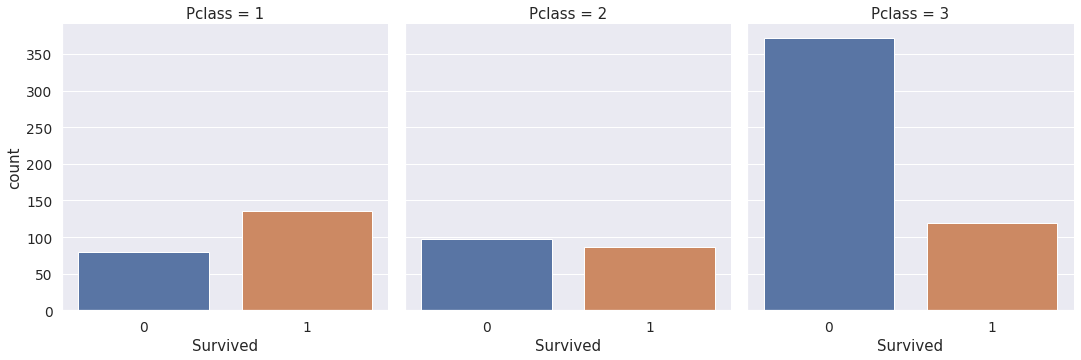

In [162]:
import seaborn as sns 
sns.catplot(x='Survived', col='Pclass', kind='count', data=train);

***survival vs non-survival according to class***

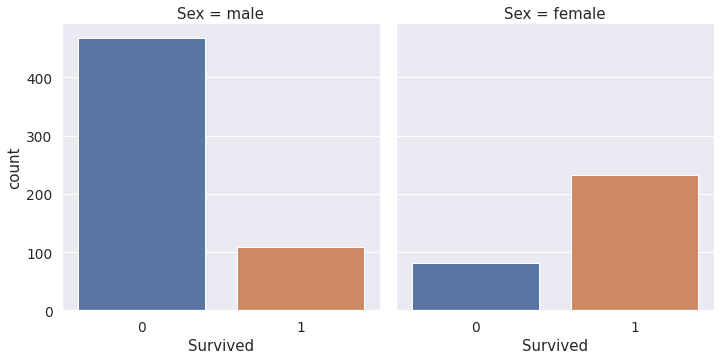

In [163]:
sns.catplot(x='Survived', col='Sex', kind='count', data=train);

***survival vs non-survival according to gender***

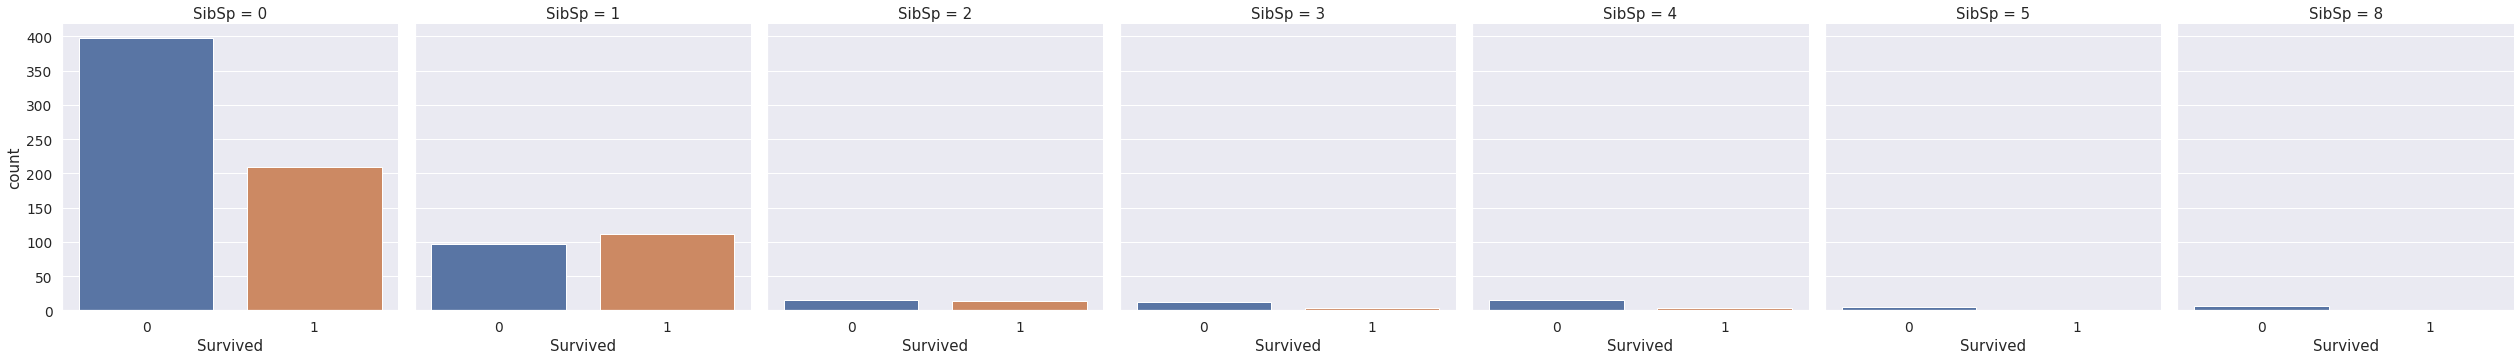

In [164]:
sns.catplot(x='Survived', col='SibSp', kind='count', data=train);

***how many survived having different numbers of siblings and spouses on ship***

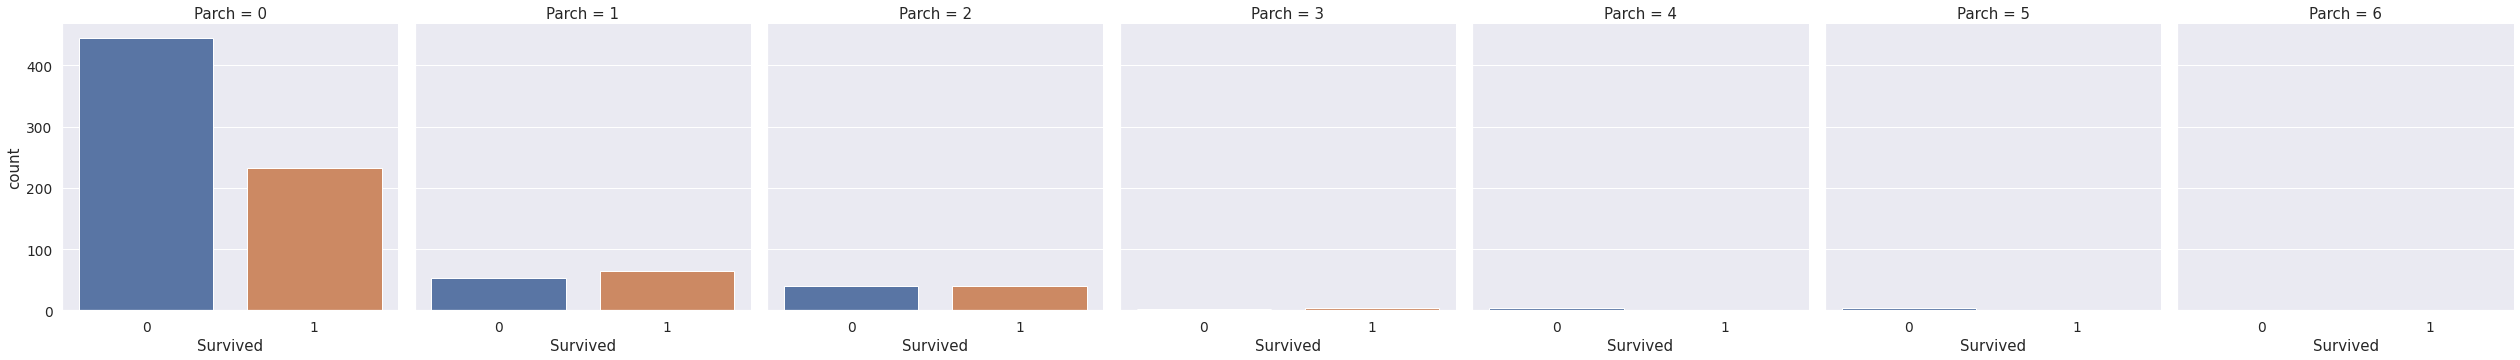

In [165]:
sns.catplot(x='Survived', col='Parch', kind='count', data=train);

***how many survived having different numbers of children and parents on ship***

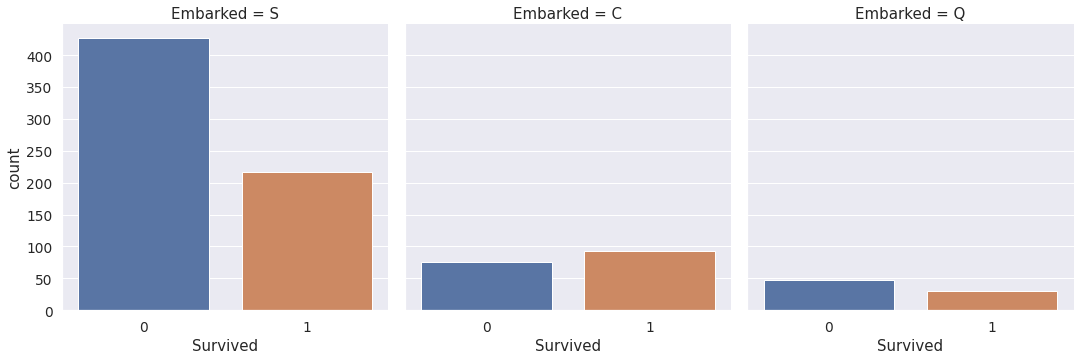

In [166]:
sns.catplot(x='Survived', col='Embarked', kind='count', data=train);

***how many survived in each Embarked port***

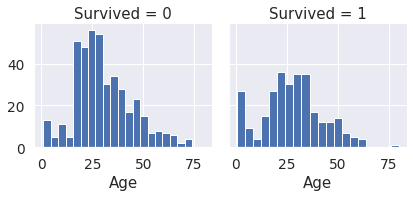

In [167]:
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Age', bins=20)

***A histogram between age and survival show that as age grows survival chances decreases***

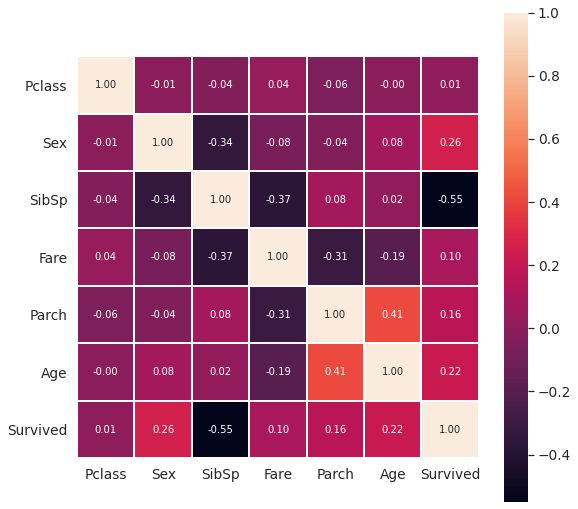

In [168]:
Features_trials = ["Pclass", "Sex", "SibSp","Fare","Parch","Age","Survived"]
plt.figure(figsize=(9, 9))
sns.set(font_scale=1.25)
sns.heatmap(train.corr(), linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=Features_trials , xticklabels=Features_trials
            )
plt.yticks(rotation=0)
plt.show()

**a correlation matrix to see the correlation coeeficient of each suggested feature with the "survived" feature - used for the feature extraction**

***Note: the "Embarked" feature decreased the kaggle score in this model, so I decided not to take it***

**from here I dicovered that siblings/spouse count is not an important feature to predict**

**The following is preproccessing for the test and train data:**

* the male and female were replaced by numbers for the model to work
* the age was normalized using the MaxMinscaler to be within 0 to 1 and the null values was filled with -1s
* the Fare was also normalized using the same scaler and the 0 values was filled with the mean fare value
* lastly the unused features like the name, ticket, cabinet were removed (dropped) and the train data is printed to make sure it is fine

In [169]:
gender = {'male': 0,'female': 1}
train.Sex = [gender[item] for item in train.Sex]
test.Sex = [gender[item] for item in test.Sex]
    

from sklearn import preprocessing

std_scale = preprocessing.MinMaxScaler().fit(train[['Age', 'Fare']])
train[['Age', 'Fare']] = std_scale.transform(train[['Age', 'Fare']])

std_scale = preprocessing.MinMaxScaler().fit(test[['Age', 'Fare']])
test[['Age', 'Fare']] = std_scale.transform(test[['Age', 'Fare']])

MeanVal = train['Fare'].mean()
train['Fare'] = train['Fare'].fillna(MeanVal)
train["Age"].fillna("-1", inplace = True)

MeanVal = test['Fare'].mean()
test['Fare'] = test['Fare'].fillna(MeanVal)
test["Age"].fillna("-1", inplace = True)


train.drop(['Name','Ticket','Cabin'],axis=1,inplace=True)
test.drop(['Name','Ticket', 'Cabin'],axis=1,inplace=True)

print(train)

     PassengerId  Survived  Pclass  Sex       Age  SibSp  Parch      Fare  \
0              1         0       3    0  0.271174      1      0  0.014151   
1              2         1       1    1  0.472229      1      0  0.139136   
2              3         1       3    1  0.321438      0      0  0.015469   
3              4         1       1    1  0.434531      1      0  0.103644   
4              5         0       3    0  0.434531      0      0  0.015713   
..           ...       ...     ...  ...       ...    ...    ...       ...   
886          887         0       2    0  0.334004      0      0  0.025374   
887          888         1       1    1  0.233476      0      0  0.058556   
888          889         0       3    1        -1      1      2  0.045771   
889          890         1       1    0  0.321438      0      0  0.058556   
890          891         0       3    0  0.396833      0      0  0.015127   

    Embarked  
0          S  
1          C  
2          S  
3          S  


****These are the final Features used: ****

In [170]:
Features = ["Pclass", "Sex","Fare","Parch", "Age"]

**stratified shuffle split to divide the train data for 20% to validate the model before submission and 80% for the model to train on**


**the ratio of males tomales in the 20 and 80 is the same as n the whole train data**

In [171]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(train, train["Sex"]):
    strat_train_set = train.loc[train_index]
    strat_test_set = train.loc[test_index]

**splitting the predicted feature from other features**

In [172]:
X_train = strat_train_set[Features]
y_train = strat_train_set["Survived"] 
X_validation = strat_test_set[Features]
y_validation = strat_test_set["Survived"]

**selecting & training the model:**

Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable and this is the model that I used here. 

Note: I tried using random forrest, Decision tree but it gave me less score

In [173]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
Y_pred = logreg.predict(X_validation)
score1 = logreg.score(X_validation, y_validation)
print(score1)

0.7988826815642458


In [174]:
#Random Forrest
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=2)
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_validation)
score2 = random_forest.score(X_validation, y_validation)
print(score2)

0.7653631284916201


In [175]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
decisiontree = DecisionTreeClassifier(random_state= 3)
decisiontree.fit(X_train, y_train)
y_pred = decisiontree.predict(X_validation)
score3 = decisiontree.score(X_validation, y_validation)
print(score3)

0.8100558659217877


***prediction and calculating the score from the model and printing it***

**save predictions in format used for competition scoring**

**I tried submitting the random forrest and decision tree but both had overfitting issues, the highest score and least overfitting was obtained from the logistic regression model**

In [176]:
test_trial=test[Features]
test_preds = logreg.predict(test_trial)

output = pd.DataFrame({'PassengerId': test.PassengerId,
                       'Survived': test_preds})
print(output)
output.to_csv('submission.csv', index=False)

     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]
